# LAB 4 (The Temperature Problem)

In [1]:
import numpy as np 

#sparse linear algebra
import scipy.sparse.linalg as spla
from scipy import sparse

#plotting
import matplotlib.pyplot as plt
from matplotlib import cm

## Some tools before we get started 
#### 1. <b> Flattening a 2D matrix to 1D </b>

In [2]:
# "Flattening" a numpy array converts it to a one dimensional vector
A = np.array([[0,   1,  2,  3,  4],
              [5,   6,  7,  8, 9],
              [10, 11, 12, 13, 14]])

A_ = A.flatten()

print(f"A:\n {A}\n")
print(f"A_ = A.flatten():\n {A_}")

A:
 [[ 0  1  2  3  4]
 [ 5  6  7  8  9]
 [10 11 12 13 14]]

A_ = A.flatten():
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]


#### 2. <b> Converting a 2D index to 1D </b>
When we flatten a 2D array A, we sacrifice the convenience of accessing elements using a two-dimensional index (x, y). Nevertheless, we can still determine the new one-dimensional index if we have information about the width of the original array.

For a given 2D index (i, j), the corresponding one-dimensional index (k) for the "flattened" array is calculated as follows:
$$
k = j + \text{{array\_width}} \times i 
$$
The operation $j + \text{{width}} \cdot i$ takes the column index ($j$) and adds it to the product of the total number of columns ($\text{{width}}$) and the row index ($i$). This combination creates a unique single index that represents the position of an element in a 2D array when it's flattened into a 1D sequence.

In [3]:
# let's say we want to access the element in A[2, 3] af ter flattening A
length, width = A.shape
i = 1
j = 1

# location of A[i, j] in flattened A
k = j + width*i 

# neighbors of A[i, j] - left, right, above, below
k1 = (j+1) +     i*width  # right
k2 = (j-1) +     i*width  # left
k3 = j     + (i+1)*width  # above
k4 = j     + (i-1)*width  # below


A_ = A.flatten()
assert A_[k]  == A[i, j]
assert A_[k1] == A[i, j+1]
assert A_[k2] == A[i, j-1]
assert A_[k3] == A[i+1, j]
assert A_[k4] == A[i-1, j]

#### 2. <b>Sparse diagonal matrices </b>
The `sparse.diags()` function allows you to define a sparse diagonal matrix. You provide the locations of the diagonals as arguments, where 0 represents the main diagonal, 1 represents the diagonal above the main diagonal, and -1 represents the diagonal below the main diagonal.

In [4]:
# Sparse diagonal matrices can be defined easily with scipy
S1 = sparse.diags([7], [0], shape=(5, 5))        # Set the 0th diagonal (main diagonal) to sevens
S2 = sparse.diags([7, 8], [0, 1], shape=(5, 5))  # Set the 0th diagonal to 7 and the 1st diagonal (diagonal above the main diagonal) as 8
S3 = sparse.diags([7, 8], [0, -1], shape=(5, 5)) # Set the 0th diagonal to 7 and the -1st diagonal (diagonal below the main diagonal) as 8
S4 = sparse.diags([7, 8, 9, 10, 11], [-2, -1, 0, 1, 2], shape=(5, 5)) 

print(f"S1 (sparse.diags([7], [0], shape=(5, 5))) = \n {S1.toarray()} \n")
print(f"S2 (sparse.diags([7, 8], [0, 1], shape=(5, 5))) = \n {S2.toarray()} \n")
print(f"S3 (sparse.diags([7, 8], [0, -1], shape=(5, 5))) = \n {S3.toarray()} \n")
print(f"S4 (sparse.diags([7, 8, 9, 10, 11], [-2, -1, 0, 1, 2], shape=(5, 5)) ) = \n {S4.toarray()}")

S1 (sparse.diags([7], [0], shape=(5, 5))) = 
 [[7. 0. 0. 0. 0.]
 [0. 7. 0. 0. 0.]
 [0. 0. 7. 0. 0.]
 [0. 0. 0. 7. 0.]
 [0. 0. 0. 0. 7.]] 

S2 (sparse.diags([7, 8], [0, 1], shape=(5, 5))) = 
 [[7. 8. 0. 0. 0.]
 [0. 7. 8. 0. 0.]
 [0. 0. 7. 8. 0.]
 [0. 0. 0. 7. 8.]
 [0. 0. 0. 0. 7.]] 

S3 (sparse.diags([7, 8], [0, -1], shape=(5, 5))) = 
 [[7. 0. 0. 0. 0.]
 [8. 7. 0. 0. 0.]
 [0. 8. 7. 0. 0.]
 [0. 0. 8. 7. 0.]
 [0. 0. 0. 8. 7.]] 

S4 (sparse.diags([7, 8, 9, 10, 11], [-2, -1, 0, 1, 2], shape=(5, 5)) ) = 
 [[ 9. 10. 11.  0.  0.]
 [ 8.  9. 10. 11.  0.]
 [ 7.  8.  9. 10. 11.]
 [ 0.  7.  8.  9. 10.]
 [ 0.  0.  7.  8.  9.]]


## Numerical Solution of the Poisson Equation
The derivative operation for a single variable is defined as:
$$
\frac{d}{dx}u(x) = \lim_{{h \to 0}} \frac{u(x+h) - u(x)}{h}.
$$

Upon differentiating again, we obtain:

$$
\frac{d^2}{dx^2}u(x) = \lim_{{h \to 0}} \frac{u(x+h) - 2u(x) + u(x-h)}{h^2}.
$$

By representing the function values in matrix form:

$$
\begin{bmatrix}
u(0) \\ \vdots \\ u(x-h) \\ u(x) \\ u(x+h) \\ \vdots \\ u(n)
\end{bmatrix}
$$

we can express the matrix that computes the second derivative (assuming \(h=1\)) as:

$$
\begin{bmatrix}
\ddots   & \ddots   &         &         & \\ 
\ddots   & \ddots   & \ddots  &         & \\ 
         & 1        & -2      &  1      & \\ 
         &          &\ddots   & \ddots  & \ddots\\ 
         &          &         & \ddots  & \ddots
\end{bmatrix}
\begin{bmatrix}
u(0) \\ \vdots \\ u(x-h) \\ u(x) \\ u(x+h) \\ \vdots \\ u(n)
\end{bmatrix} =
\begin{bmatrix}
-2u(0) + u(h) \\ \vdots \\ \vdots \\ u(x-h) - 2u(x) + u(x+h) \\ \vdots \\ \vdots \\ u(n-h)-2u(n)
\end{bmatrix},
$$

where the white spaces in the matrix represent 0.

### Poisson equation in two dimensions (length and width)

Moving on to the Poisson heat equation in two dimensions:

$$
f(x, y) = -\nabla^2 u(x, y)
$$

1. $f(i, j)$ represents the heat flowing into the system at point $(i, j)$.
2. $u(i, j)$ denotes the temperature of the system at point $(i, j)$.

The discretization of the Laplacian operator $\nabla^2$ is analogous to the one-variable case:

$$
\begin{align}
\nabla^2 u(x, y) &= \frac{\partial^2 }{\partial x^2}u(x,y)+\frac{\partial^2}{\partial y^2}u(x,y) \\
 &= \frac{u(x+h, y) - 2u(x, y) + u(x-h, y)}{h^2} + \frac{u(x, y+h) - 2u(x, y) + u(x, y-h)}{h^2}\\
 &= \frac{1}{h^2} (u(x+h, y) + u(x-h, y) + u(x, y+h) + u(x, y-h) - 4u(x, y))\\
\end{align}
$$

In [5]:
length = 100 
width  = 200            
sys_size = length*width  # We have to compute heat values for x*y points 

Similar to the one-variable case, this can be represented as a linear system.
$$
\begin{bmatrix}
\ddots   & \ddots   &         &\ddots   &         &         &         &           &          \\ 
\ddots   & \ddots   & \ddots  &         & \ddots  &         &         &           &          \\ 
         & \ddots   & \ddots  & \ddots  &         & \ddots  &         &           &          \\ 
\ddots   &          & \ddots  & \ddots  & \ddots  &         & \ddots  &           &          \\ 
         & 1        &         & 1       & -4      & 1       &         &   1       &          \\ 
         &          & \ddots  &         & \ddots  & \ddots  & \ddots  &           &   \ddots \\
         &          &         & \ddots  &         & \ddots  & \ddots  & \ddots    &          \\
         &          &         &         &  \ddots &         & \ddots  & \ddots    &   \ddots \\
         &          &         &         &         & \ddots  &         & \ddots    &   \ddots \\
\end{bmatrix}
\begin{bmatrix} u(0, 0) \\ \vdots \\ u(x-1, y) \\ \vdots \\ u(x, y-1) \\ u(x, y) \\ u(x, y+1) \\ \vdots \\ u(x+1, y) \\ \vdots \\ u(n, n)\end{bmatrix} =
\begin{bmatrix} -4u(0, 0)+u(x, y+1)+u(x+1, y) \\ \vdots \\ \vdots \\u(x+1, y) + u(x-1, y) + u(x, y+1) + u(x, y-1) - 4u(x, y) \\ \vdots \\ \vdots \\ -4u(n, n)+u(n, n-1)+u(n-1, y) \end{bmatrix}
$$

What is the space between u(x+1, y) and u(x, y)? it is the width of the system.

In [6]:
# generate sparse matrix (4 diagonals)
diag_positions = [-width, -1, 0, 1, width]
diag_values    = [-1, -1, 4, -1, -1]
A = sparse.diags(diag_values, diag_positions, shape=(sys_size, sys_size))

Text(0.5, 1.0, 'Heat source placement (RHS)')

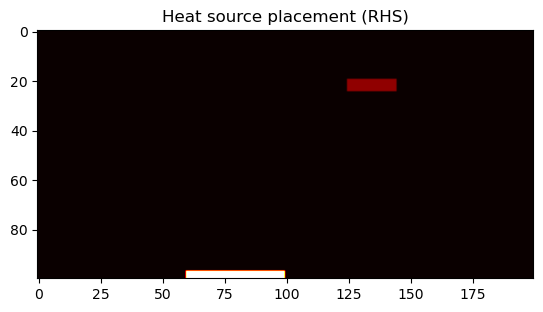

In [7]:
# Lets place two heat sources in the environment with different intensities 
heat_source1_intensity = 1
heat_source2_intensity = 0.2


# define the heat flux (right hand side)
heat_flux                 = np.zeros(shape=(length, width))
heat_flux[-3:, 60:100]    = heat_source1_intensity # heat source 1   
heat_flux[20:25, 125:145] = heat_source2_intensity # heat source 2  

# flatten the environment
b = heat_flux.flatten() 

# visualizing the environment with heat sources
plt.imshow(heat_flux, cmap=cm.hot)
plt.title("Heat source placement (RHS)")

Text(0.5, 1.0, 'Solution')

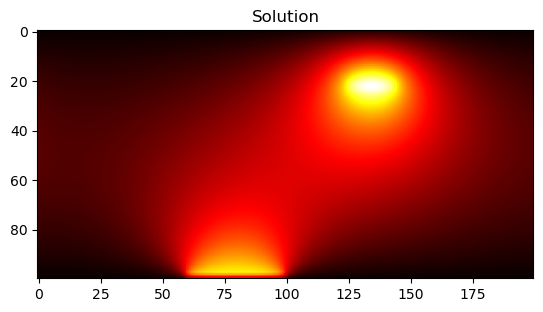

In [8]:
# convert A into a CSR matrix
A = sparse.csr_matrix(A)

# solve the system 
u = spla.spsolve(A, b)

#plot
plt.imshow(u.reshape(length, width), cmap=cm.hot)
plt.title("Solution")

Text(0.5, 1.0, 'Heat source placement (RHS)')

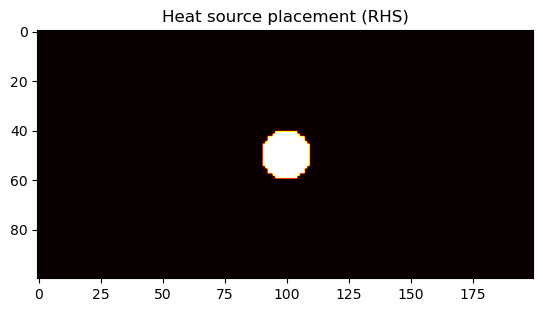

In [11]:
# circular heat source 
heat_flux = np.zeros(shape=(length, width))
circle_pos = np.array([length/2, width/2])
circle_radius = 10

for i in range(length):
    for j in range(width):
        if np.linalg.norm(np.array([i, j] - circle_pos)) < circle_radius:
            heat_flux[i, j] = 1
            
# visualizing the environment with heat sources
plt.imshow(heat_flux, cmap=cm.hot)
plt.title("Heat source placement (RHS)")

Text(0.5, 1.0, 'Solution')

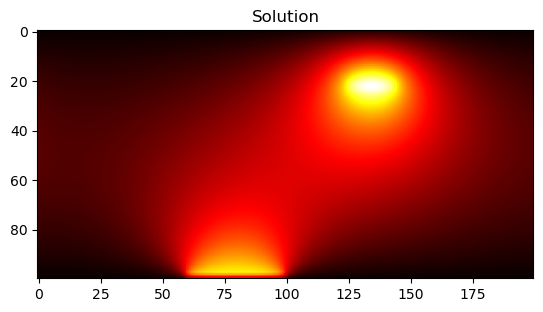

In [13]:
# solve the system 
u = spla.spsolve(A, b)

#plot
plt.imshow(u.reshape(length, width), cmap=cm.hot)
plt.title("Solution")